# Introduction

Recommendation Engines/Systems have become an integral part of our online interactions. From video streaming websites, to e-commerce, recommendation engines play an important role in enhancing user experience. In this problem, we have a website for competitive programming wherein users solve different programmatic problems and earn points to achieve different levels of expertise (beginner, intermediate, advanced, and expert). We will aim to build a recommendation engine for the users, based on their past behavior, to suggest them new problems to solve and hence keep them engaged on the website. We will first do some feature engineering and then proceed to build a recommendation engine based on a hybrid model.

The data available to us is in three different files as following:
    1. user_data:- information about different characteristics of all the users
    2. problem_data:- information about different characteristics of all the problems
    3. submissions_data:- list of all problems solved by a particular user.
    
So, as always, let's first start with looking for missing values and then move on to feature engineering.

## Exploratory Data Analysis
 
We'll import the data from csv files and store it in dataframes.

In [1]:
#Setting the path
setwd("/home/ankit19/Desktop/Jupyter_Notebooks/Recommendation Engine")

#Importing data
UserData = read.csv("data/user_data.csv", stringsAsFactors=F)
ProblemData = read.csv("data/problem_data.csv", stringsAsFactors=F)
SubmissionsData = read.csv("data/submissions_data.csv", stringsAsFactors=F)

#Summarizing data
print("User information")
summary(UserData)

print("Problem information")
summary(ProblemData)

print("Submission information")
summary(SubmissionsData)

[1] "User information"


   user_id          submission_count successful_submissions expertise_level   
 Length:3571        Min.   :   1.0   Min.   :   0.0         Length:3571       
 Class :character   1st Qu.:  66.5   1st Qu.:  53.0         Class :character  
 Mode  :character   Median : 169.0   Median : 146.0         Mode  :character  
                    Mean   : 299.5   Mean   : 267.9                           
                    3rd Qu.: 390.0   3rd Qu.: 349.0                           
                    Max.   :4570.0   Max.   :4476.0                           

[1] "Problem information"


  problem_id         level_type            points         tags          
 Length:6544        Length:6544        Min.   : 250   Length:6544       
 Class :character   Class :character   1st Qu.: 500   Class :character  
 Mode  :character   Mode  :character   Median : 750   Mode  :character  
                                       Mean   : 892                     
                                       3rd Qu.:1250                     
                                       Max.   :2000                     
                                       NA's   :771                      

[1] "Submission information"


   user_id           problem_id       
 Length:155295      Length:155295     
 Class :character   Class :character  
 Mode  :character   Mode  :character  

From the summary we get information of the number of NAs in numerical columns but we don't get any information on blank fields in character columns. Let's go through the columns of each dataframe to see number of blank fields.

In [2]:
print("User information")
print(paste("Blanks in user_id: ", sum(grepl("^\\s*$", UserData$user_id) == TRUE)))
print(paste("Blanks in expertise_level: ", sum(grepl("^\\s*$", UserData$expertise_level) == TRUE)))

[1] "User information"
[1] "Blanks in user_id:  0"
[1] "Blanks in expertise_level:  0"


In [3]:
print("Problem information")
print(paste("Blanks in problem_id: ", sum(grepl("^\\s*$", ProblemData$problem_id) == TRUE)))
print(paste("Blanks in level_type: ", sum(grepl("^\\s*$", ProblemData$level_type) == TRUE)))
print(paste("Blanks in tags: ", sum(grepl("^\\s*$", ProblemData$tags) == TRUE)))

[1] "Problem information"
[1] "Blanks in problem_id:  0"
[1] "Blanks in level_type:  133"
[1] "Blanks in tags:  3484"


In [4]:
print("Submissions information")
print(paste("Blanks in user_id: ", sum(grepl("^\\s*$", SubmissionsData$user_id) == TRUE)))
print(paste("Blanks in problem_id: ", sum(grepl("^\\s*$", SubmissionsData$problem_id) == TRUE)))

[1] "Submissions information"
[1] "Blanks in user_id:  0"
[1] "Blanks in problem_id:  0"


So only the ProblemData has NAs in "level_type", "tags", and "points" fields. We see that the number of blanks in tags is almost half of the total number of observations. We can choose to drop this column but I think we can extract valuable information about the problems for it so we won't go ahead and drop it directly but manipulate our dataframes and essentially clean them before we move on to building any models.

## Data Manipulation

In this subsection we'll deal with the missing values in ProblemData. First we will drop all such observations where we have missing values for "level_type", "points", and "tags". The reason for this is that these three columns define the problem and if an observation has missing values for all three of them then it becomes very difficult to impute values. One could impute "points" with the average or median value but that wouldn't be the best approach because it can be assumed that the points are directly proportional to difficulty level. Also, "level_type" cannot be imputed right away for similar reasons.

We must keep this in mind that we will also have to drop the observations from SubmissionsData where "problem_id" is one of the IDs dropped from ProblemData. First let's get an idea of how many such observations exist in ProblemData.

In [5]:
#Substituting blanks
ProblemData$level_type[grepl("^\\s*$", ProblemData$level_type) == TRUE] = "NA"
ProblemData$tags[grepl("^\\s*$", ProblemData$tags) == TRUE] = "MISC"

In [6]:
#Library for data manipulations
library(dplyr)

#Filtering out the blanks
blanks = ProblemData %>%
            filter(level_type == "NA" & is.na(points) & tags == "MISC") %>%
            select(problem_id)

head(blanks)
nrow(blanks)

Warning message:
“package ‘dplyr’ was built under R version 3.4.4”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

problem_id


[1] 0

As we can see there are no such IDs that satisfy the above condition hence we won't have to drop any observations in either of the tables. Let's move on to imputing missing values in level_type.

In [7]:
sum(ProblemData$level_type == "NA")

[1] 133

Although the number of missing values is relatively quite small to the total number of observations, we should see if we can impute these values. So let's start that by first getting an idea of the average points for each level_type.

In [8]:
ProblemData %>%
    group_by(level_type) %>%
    summarize(mean_points = mean(points, na.rm=T))

level_type,mean_points
A,250.0000
B,500.0000
C,750.0000
D,1000.0000
E,1250.0000
F,1500.0000
G,1750.0000
H,2000.0000
I,NaN
J,NaN


This confirms that with increasing level_type the points increase as well. Hence the difficulty level of a problem increases in that same order.

In [9]:
points_levels = factor(ProblemData$points)
nlevels(points_levels)
levels(points_levels)

[1] 8

[1] "250"  "500"  "750"  "1000" "1250" "1500" "1750" "2000"

Looking at the factors it becomes evident that with each level there's an increase in 250 points. Using that, we can extrapolate the points for the level_type after H. 

In [10]:
ProblemData$points[ProblemData$level_type == "I"] = 2250
ProblemData$points[ProblemData$level_type == "J"] = 2500
ProblemData$points[ProblemData$level_type == "K"] = 2750
ProblemData$points[ProblemData$level_type == "L"] = 3000
ProblemData$points[ProblemData$level_type == "M"] = 3250
ProblemData$points[ProblemData$level_type == "N"] = 3500

Now let's look at the missing values of level_type and see if we can assign them any appropriate value.

In [11]:
summary(ProblemData$points[ProblemData$level_type == "NA"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  250.0   250.0  1000.0   757.5  1000.0  2000.0 

In [12]:
#No of occurences in each quartiles
print(paste("NAs having points <= 250: ", sum(ProblemData$level_type == "NA" & ProblemData$points <= 250)))
print(paste("NAs having points between 250 and 1000: ", sum(ProblemData$level_type == "NA" & ProblemData$points > 250 & ProblemData$points <= 1000)))
print(paste("NAs having points greater than 1000: ", sum(ProblemData$level_type == "NA" & ProblemData$points > 1000 & ProblemData$points <= 2000)))

[1] "NAs having points <= 250:  51"
[1] "NAs having points between 250 and 1000:  76"
[1] "NAs having points greater than 1000:  6"


In [13]:
#Substituting NA with actual value
ProblemData$level_type[ProblemData$level_type == "NA" & ProblemData$points == 250] = "A"
ProblemData$level_type[ProblemData$level_type == "NA" & ProblemData$points == 1000] = "D"
ProblemData$level_type[ProblemData$level_type == "NA" & ProblemData$points == 2000] = "H"

In [14]:
#Checking for residual NA in level_type
sum(ProblemData$level_type == "NA")

[1] 0

Now all the null values have been eliminated from ProblemData.

## Feature Engineering

We will introduce some features in UserData to improve the performance of our recommendation engine. These features will be:
    1. success_rate:- the ratio of success number of submissions to total submissions
    2. learner_player:- is the user more inclined towards learning or more inclined towards competing?
    3. level_up:- is the user about to level up to next expertise level?
    
We'll get to the hypothesis and procedure behind each of these features in the following sections. Let's start with the easiest feature, success_rate.

In [15]:
UserData$success_rate = round(UserData$successful_submissions/UserData$submission_count, 2)
head(UserData)

user_id,submission_count,successful_submissions,expertise_level,success_rate
user_3311,47,40,intermediate,0.85
user_3028,63,52,intermediate,0.83
user_2268,226,203,beginner,0.90
user_480,611,490,advanced,0.80
user_650,504,479,advanced,0.95
user_3177,3,1,intermediate,0.33


In [16]:
#Dropping submission_count and successful_submissions
UserData$successful_submissions = NULL
UserData$submission_count = NULL

For determining whether a user is an active learner or a competitive player we will build upon the hypothesis that if a user solves a greater proportion of problems that have some tags i.e. some topics associated with it then he's a learner. Conversely, if a user has a lesser proportion of problems with tags and instead goes for problems with higher points then he's a competitive player. To include this variable/feature in UserData we'll first have to determine how many of the user's submissions have tags with them. We'll have to make use of the other two dataframes for this purpose. Note that "MISC" is not a tag and it has been used in place of blanks to make things easier hence we'll consider every problem with a "MISC" tag to have no tags associated with it.

In [17]:
#Perform join with ProblemData on problem_id for SubmissionsData
#Create a new column has_tags with Y if tags are present and N if not
#Drop tags column and rearrange the columns
SubmissionsData = ProblemData %>%
                    select(problem_id, tags) %>%
                    right_join(SubmissionsData, by = c("problem_id" = "problem_id")) %>%
                    mutate(has_tags = ifelse(tags == "MISC", "N", "Y")) %>%
                    select(-tags) %>%
                    select(user_id, problem_id, has_tags)

SubmissionsData

user_id,problem_id,has_tags
user_232,prob_6507,Y
user_3568,prob_2994,Y
user_1600,prob_5071,Y
user_2256,prob_703,Y
user_2321,prob_356,Y
user_1569,prob_6064,Y
user_3293,prob_1237,Y
user_915,prob_4125,Y
user_2032,prob_1943,Y
user_1410,prob_3935,Y


In [18]:
#Get the number of problems with tags by user_id
UserLearningStats = SubmissionsData %>% group_by(user_id) %>% 
                    mutate(tags_present = sum(has_tags == "Y")) %>% 
                    select(user_id, tags_present)

#Get the total number of problems by user_id and get the learning ratio
UserLearningStats = SubmissionsData %>%
                    group_by(user_id) %>%
                    summarize(total_count = n()) %>%
                    right_join(UserLearningStats, by = c("user_id" = "user_id")) %>%
                    mutate(learning_ratio = round(tags_present/total_count, 2)) %>%
                    select(user_id, tags_present, total_count, learning_ratio) %>%
                    distinct()

UserLearningStats

user_id,tags_present,total_count,learning_ratio
user_232,30,31,0.97
user_3568,44,44,1.00
user_1600,27,27,1.00
user_2256,54,56,0.96
user_2321,65,68,0.96
user_1569,59,79,0.75
user_3293,48,61,0.79
user_915,44,57,0.77
user_2032,72,73,0.99
user_1410,52,52,1.00


In [19]:
#Distribution of learning_ratio values
summary(UserLearningStats$learning_ratio)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.90    0.98    0.91    1.00    1.00 

From this distribution it becomes evident that a larger proportion of our users are active learners. The reason that I decided to look at this distribution is because if I had arbitrarily decided a threshold value, say 0.50, for learning_ratio to categorize a user as a learner or a player, I would have definitely miscategorized a lot of users. Since the first quartile is 0.90 let's see how many users fall under the categories of learners and players when we keep the threshold at 0.90.

In [20]:
nrow(UserLearningStats)
sum(UserLearningStats$learning_ratio <= 0.90)
sum(UserLearningStats$learning_ratio > 0.90)

[1] 3529

[1] 890

[1] 2639

So we see that about a quarter of users have a learning ratio of less than 0.90. We can thus classify these users as players, whereas the rest as learners. But we should take into account total number of users available in UserLearningStats. Compared to UserData, UserLearningStats have 42 fewer observations. Let's take a look at these observations.

In [21]:
#Select all such user_id that are not present in UserLearningStats
subset(UserData, !(user_id %in% UserLearningStats$user_id))
nrow(subset(UserData, !(user_id %in% UserLearningStats$user_id)))

,user_id,expertise_level,success_rate
6,user_3177,intermediate,0.33
155,user_2823,beginner,0.00
207,user_3427,beginner,0.29
336,user_2370,beginner,0.00
353,user_2703,intermediate,0.00
372,user_1518,beginner,0.00
598,user_3084,beginner,0.00
600,user_2209,beginner,0.00
616,user_1726,intermediate,1.00
785,user_181,beginner,0.43


[1] 42

We can see that all the 42 missing observations are accounted for and that most of these missing observations have a success_rate of 0.00 i.e. they haven't made any submissions and that they are beginners. As for the users that have a non-zero success_rate, their absence may be attributed to observation error at the source. It seems wiser to drop these observations from our UserData. We will handle "cold start" separately in our recommendation engine.

In [22]:
#Drop missing observations from UserData
UserData = subset(UserData, (user_id %in% UserLearningStats$user_id))

Now we shall create a new attribute/variable in UserData that tells us if a user is a player or a learner.

In [23]:
UserData =  UserData %>%
            left_join(UserLearningStats, by = ("user_id" = "user_id")) %>%
            mutate(learner_player =  ifelse(learning_ratio <= 0.90, "player", "learner")) %>%
            select(user_id, success_rate, expertise_level, learner_player)

Lastly, we have to make a new feature of whether a user is on the verge of leveling up. The reason I intend to add this feature is because my aim over here is that if a user is close to leveling up then he should be recommended problems of the next level or maybe problems with higher points so that he can move on to the next level. Before we go ahead with this,  we must determine what attribute of a user determines his expertise level strongly. Intuitively, it can be either a high success rate or points earned. Thus we first determine the total points the user has earned.

In [24]:
#Get points for each problem
SubmissionsData = ProblemData %>%
                    select(problem_id, points) %>%
                    right_join(SubmissionsData, by = c("problem_id" = "problem_id")) %>%
                    select(user_id, problem_id, has_tags, points)

In [25]:
#Get total points earned by users
UserData = SubmissionsData %>%
    group_by(user_id) %>%
    summarize(total_points = sum(points)) %>%
    distinct() %>%
    right_join(UserData, by = ("user_id" = "user_id")) %>%
    select(user_id, success_rate, total_points, expertise_level, learner_player)

head(UserData)

user_id,success_rate,total_points,expertise_level,learner_player
user_3311,0.85,17750,intermediate,learner
user_3028,0.83,19500,intermediate,learner
user_2268,0.90,25750,beginner,learner
user_480,0.80,26000,advanced,learner
user_650,0.95,47250,advanced,learner
user_2032,0.92,39250,intermediate,learner


To determine which of the attributes better define an expertise level, we will first plot boxplots. We'll use ggplot2 library for this.

Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”

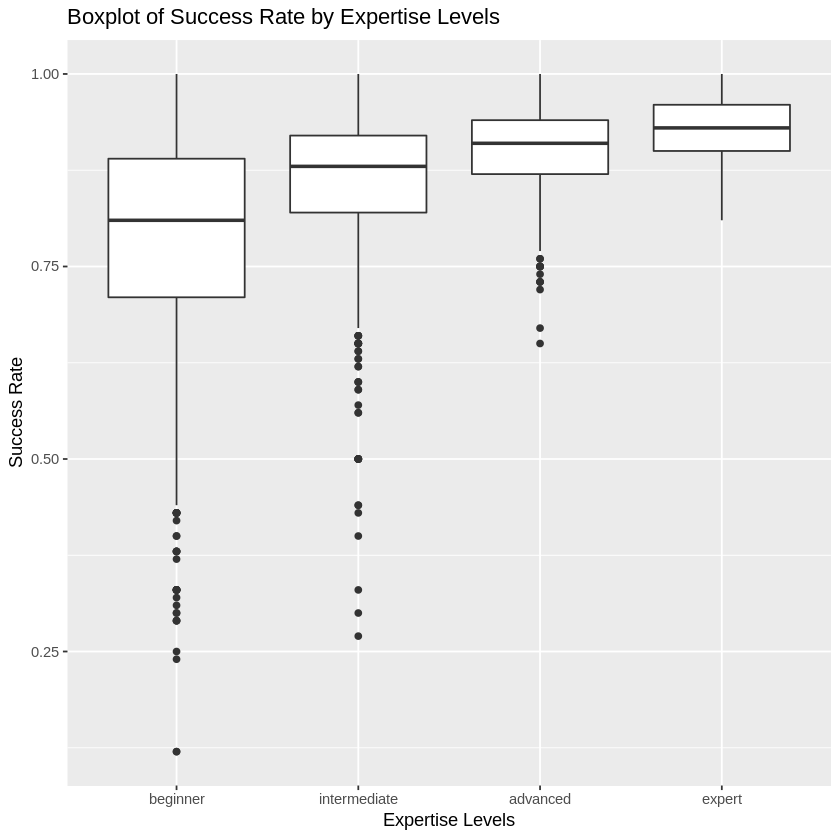

In [26]:
#Library for plotting
library(ggplot2)

#Creating factors for expertise level
UserData$expertise_level = factor(UserData$expertise_level, levels = c("beginner", "intermediate", "advanced", "expert"))

ggplot(data = UserData, aes(x=expertise_level, y=success_rate)) + geom_boxplot() + xlab("Expertise Levels") + ylab("Success Rate") + ggtitle("Boxplot of Success Rate by Expertise Levels")

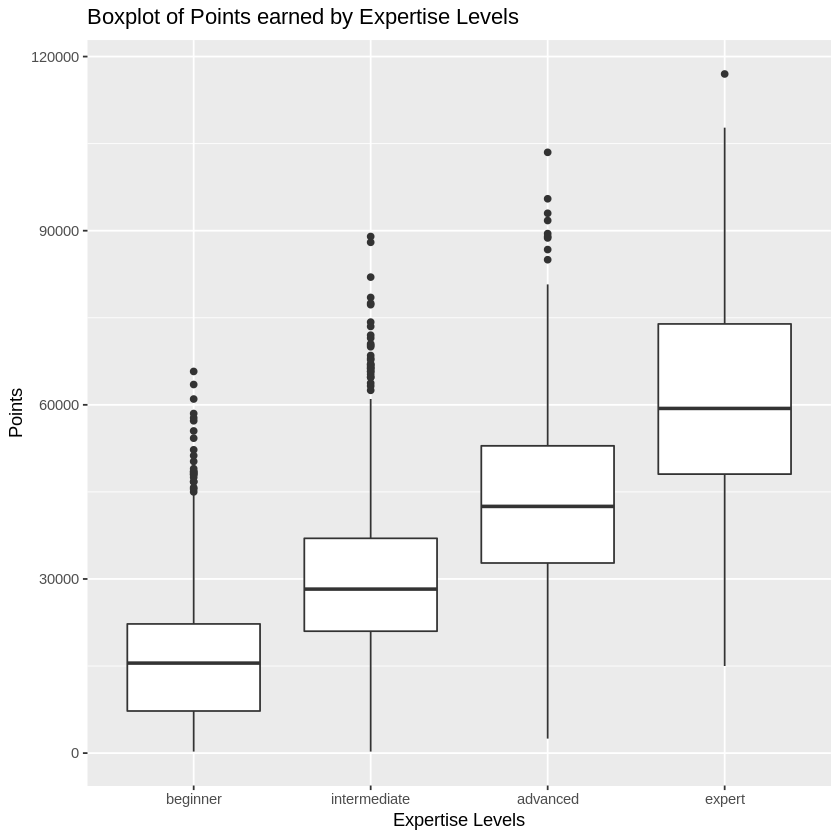

In [27]:
ggplot(data = UserData, aes(x=expertise_level, y=total_points)) + geom_boxplot() + xlab("Expertise Levels") + ylab("Points") + ggtitle("Boxplot of Points earned by Expertise Levels")

From boxplots it becomes evident that points help distinguish between expertise levels better than success rate. This inference is drawn based on the fact that the boxplots are less overlapped and have a more visible increase in the range of values for each level in the second plot of points. So we'll choose points as a determining factor for leveling up. But we still have a problem of outliers. While the first plot has fewer outliers, it has far more overlapping hence we'll treat the values of points for outliers and then plot the boxplots to see the results.

We'll use capping process to deal with outliers. The outlier values that lie outside the 1.5 * IQR limits, will be capped by replacing those observations outside the lower limit with the value of 5th %ile and those that lie above the upper limit, with the value of 95th %ile.

In [28]:
#Function for capping outliers
capOutliers = function(x){
    quantiles = quantile( x, c(.05, .95 ) )
    x[x < quantiles[1]] = quantiles[1]
    x[x > quantiles[2]] = quantiles[2]
    x
}

#Capping beginner level's points
beginnerData = subset(UserData, expertise_level == "beginner", select = c(user_id, expertise_level, success_rate, total_points, learner_player))
beginnerData$total_points = capOutliers(beginnerData$total_points)

#Capping intermediate level's points
intermediateData = subset(UserData, expertise_level == "intermediate", select = c(user_id, expertise_level, success_rate, total_points, learner_player))
intermediateData$total_points = capOutliers(intermediateData$total_points)

#Capping advanced level's points
advancedData = subset(UserData, expertise_level == "advanced", select = c(user_id, expertise_level, success_rate, total_points, learner_player))
advancedData$total_points = capOutliers(advancedData$total_points)

#Capping expert level's points
expertData = subset(UserData, expertise_level == "expert", select = c(user_id, expertise_level, success_rate, total_points, learner_player))
expertData$total_points = capOutliers(expertData$total_points)

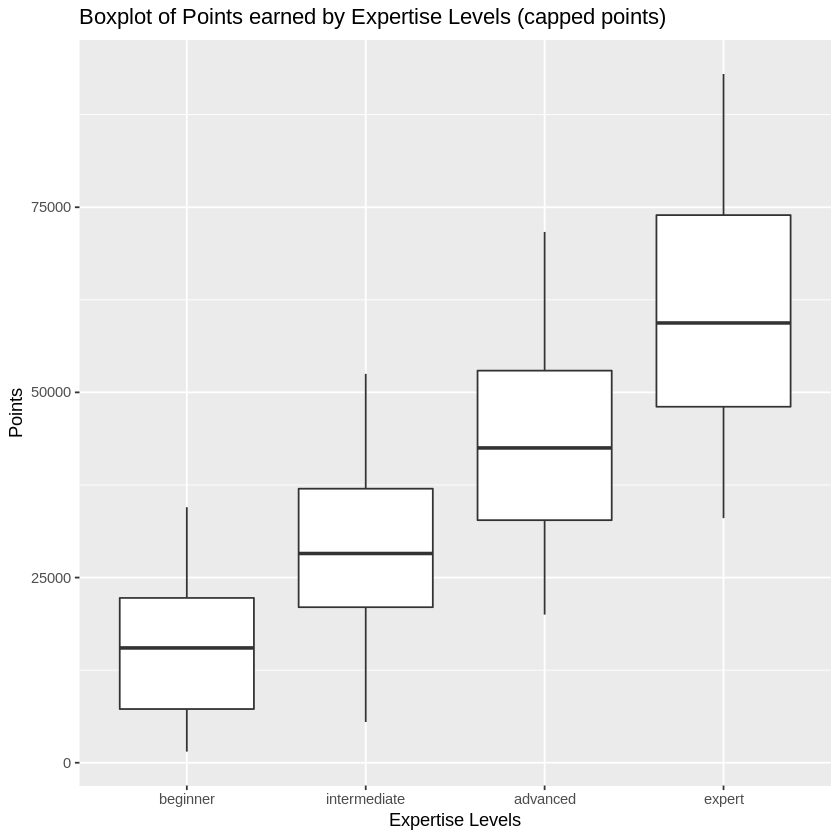

In [29]:
#Combining all capped data for different levels
cappedData = rbind(beginnerData, intermediateData, advancedData, expertData)
ggplot(data = cappedData, aes(x=expertise_level, y=total_points)) + geom_boxplot() + xlab("Expertise Levels") + ylab("Points") + ggtitle("Boxplot of Points earned by Expertise Levels (capped points)")

On close inspection of the boxplots it becomes evident that even after capping the outliers we do not get well-defined levels of points that completely distinguish different expertise levels. There is definitely some distinction in the points for each expertise level but there's also visible overlapping. From this it can be inferred that there may be other factors besides the points that determine the expertise level of a user which is clearly not available in the given data. To deal with this in the recommendation, we will have to specifically handle the overlapping values or the "grey areas", if you will. Initially I had thought that maybe a simple variable that indicated whether the points of the user was close to the next level would be sufficient but in the given scenario that's not possible. The new variable "level_up" will depict the above information which will prove helpful in recommendation. But first we'll have to observe the quartiles of each of the levels and then proceed to define a new feature in UserData.

In [30]:
summary(beginnerData$total_points)
summary(intermediateData$total_points)
summary(advancedData$total_points)
summary(expertData$total_points)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1500    7250   15500   15631   22250   34500 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5500   21000   28250   28767   37000   52500 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20000   32750   42500   43560   52938   71662 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  33025   48062   59375   61083   73938   92988 

So now based on these values I will define the following values for the new feature:
    1. FLTA - Far Less Than Average in this expertise level
    2. LTA - Less Than Average in this expertise level
    3. GTA - Greater Than Average in this expertise level
    4. FGTA - Far Greater Than Average in this expertise level
    
I will also change the name of this new feature from level_up to level_of_points. Now for recommendations I propose the following hypothesis:

1. For every expertise level, users with less than average points in the individual domains of FLTA, LTA, and GTA, must be recommended unsolved problems that other users of the domain have solved.

2. For "expert" expertise level, users with less than average points in the individual domain of FGTA, must be recommended unsolved problems that other users of the domain have solved. 

3. For every expertise level, users with greater than average points in the domain of FLTA, must be recommended with problems solved by users of the LTA domain for that expertise level.

4. For every expertise level, users with greater than average points in the domain of LTA, must be recommended with problems solved by users of the GTA domain for that expertise level.

5. For every expertise level, besides the "expert" level, users with greater than average points in the domain of GTA, must be recommended with problems solved by users of the LTA domain for the next expertise level.

6. For every expertise level, besides the "expert" level, users with points in the domain of FGTA must be recommended with problems solved by the users of the GTA domain of next expertise level. 

7. For "expert" level, users with greater than average points in domains of GTA and FGTA must be recommended with unsolved problems that other users of that domain have solved.

Let's proceed with each of the level individually.

In [31]:
#Beginner level
beginnerData$level_of_points[beginnerData$total_points <= 7250] = "FLTA"
beginnerData$level_of_points[beginnerData$total_points > 7250 & beginnerData$total_points <= 15631] = "LTA"
beginnerData$level_of_points[beginnerData$total_points > 15631 & beginnerData$total_points <= 22250] = "GTA"
beginnerData$level_of_points[beginnerData$total_points > 22250] = "FGTA"

#Intermediate level
intermediateData$level_of_points[intermediateData$total_points <= 21000] = "FLTA"
intermediateData$level_of_points[intermediateData$total_points > 21000 & intermediateData$total_points <= 28767] = "LTA"
intermediateData$level_of_points[intermediateData$total_points > 28767 & intermediateData$total_points <= 37000] = "GTA"
intermediateData$level_of_points[intermediateData$total_points > 37000] = "FGTA"

#Advanced level
advancedData$level_of_points[advancedData$total_points <= 32750] = "FLTA"
advancedData$level_of_points[advancedData$total_points > 32750 & advancedData$total_points <= 43560] = "LTA"
advancedData$level_of_points[advancedData$total_points > 43560 & advancedData$total_points <= 52938] = "GTA"
advancedData$level_of_points[advancedData$total_points > 52938] = "FGTA"

#Expert level
expertData$level_of_points[expertData$total_points <= 48062] = "FLTA"
expertData$level_of_points[expertData$total_points > 48062 & expertData$total_points <= 61083] = "LTA"
expertData$level_of_points[expertData$total_points > 61083 & expertData$total_points <= 73938] = "GTA"
expertData$level_of_points[expertData$total_points > 73938] = "FGTA"

#Combining all the dataframes and overriding the original
UserData = rbind(beginnerData, intermediateData, advancedData, expertData)
head(UserData)

#Writing all files to csv
write.csv(UserData, "data/ProcessedUserData.csv", row.names=FALSE)
write.csv(ProblemData, "data/ProcessedProblemData.csv", row.names=FALSE)
write.csv(SubmissionsData, "data/ProcessedSubmissionsData.csv", row.names=FALSE)

Warning message:
“Unknown or uninitialised column: 'level_of_points'.”Warning message:
“Unknown or uninitialised column: 'level_of_points'.”Warning message:
“Unknown or uninitialised column: 'level_of_points'.”Warning message:
“Unknown or uninitialised column: 'level_of_points'.”

user_id,expertise_level,success_rate,total_points,learner_player,level_of_points
user_2268,beginner,0.90,25750,learner,FGTA
user_3306,beginner,0.50,1500,learner,FLTA
user_1483,beginner,0.87,26500,learner,FGTA
user_1972,beginner,0.93,19000,learner,GTA
user_3031,beginner,0.94,34500,player,FGTA
user_1258,beginner,0.91,21000,player,GTA


Now that the data cleaning and pre-processing is complete we can move on to building our model (next IPython Notebook). We've saved all the processed dataframes into csv files to be used later.